In [5]:
## 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from pylab import rcParams
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [6]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [18]:
df = pd.read_csv("./Data/creditcard.csv")

In [19]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
df.shape

(284807, 31)

In [21]:
df.isnull().values.any()

False

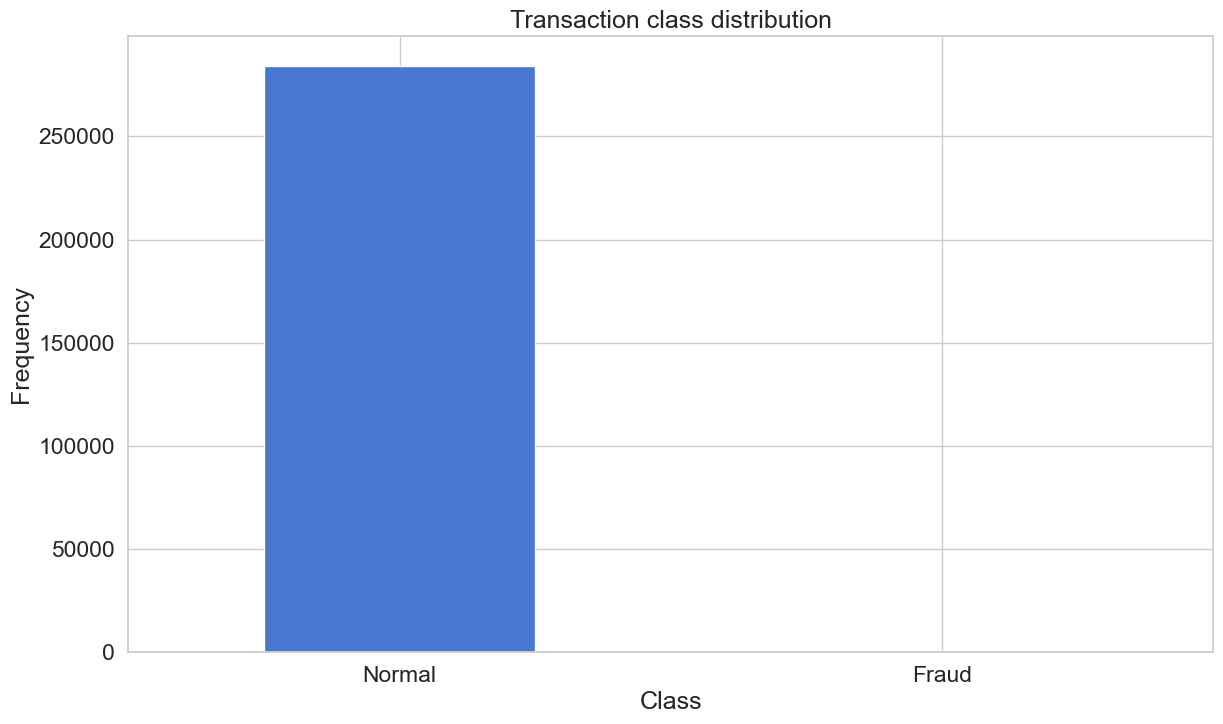

In [22]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [23]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [24]:
normal.shape

(284315, 31)

In [25]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [26]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

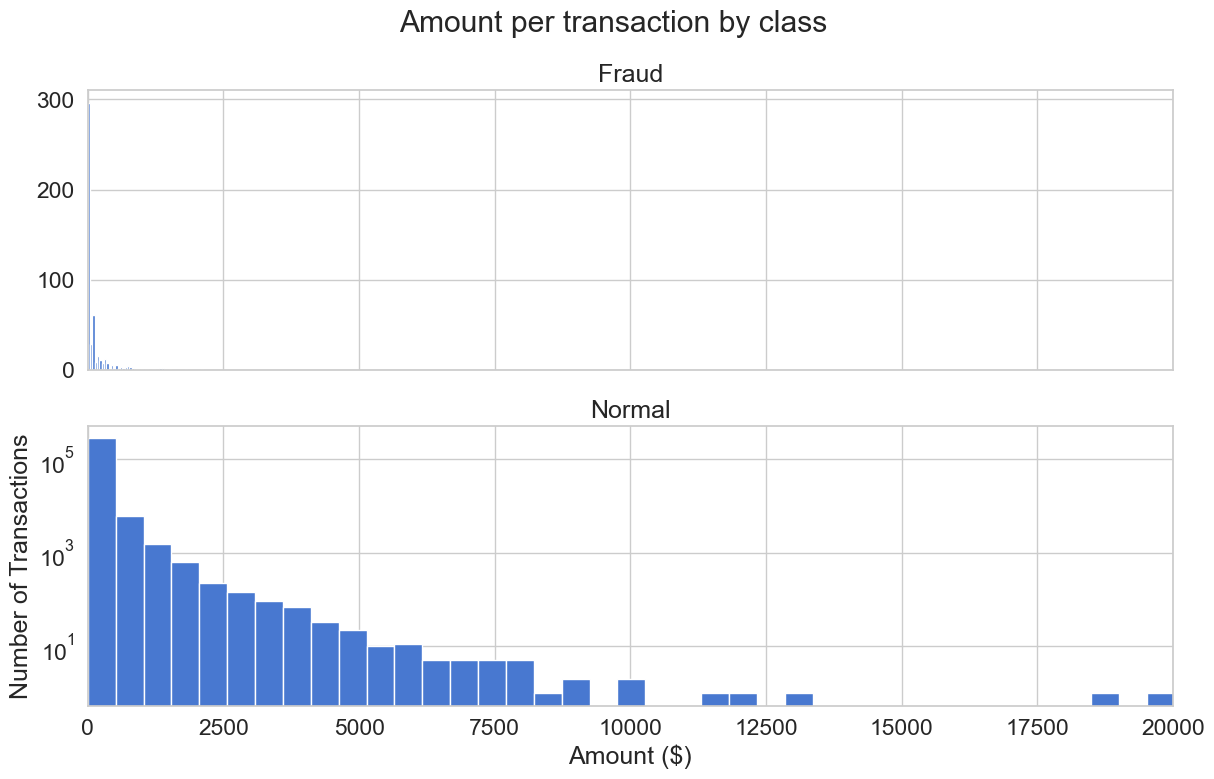

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


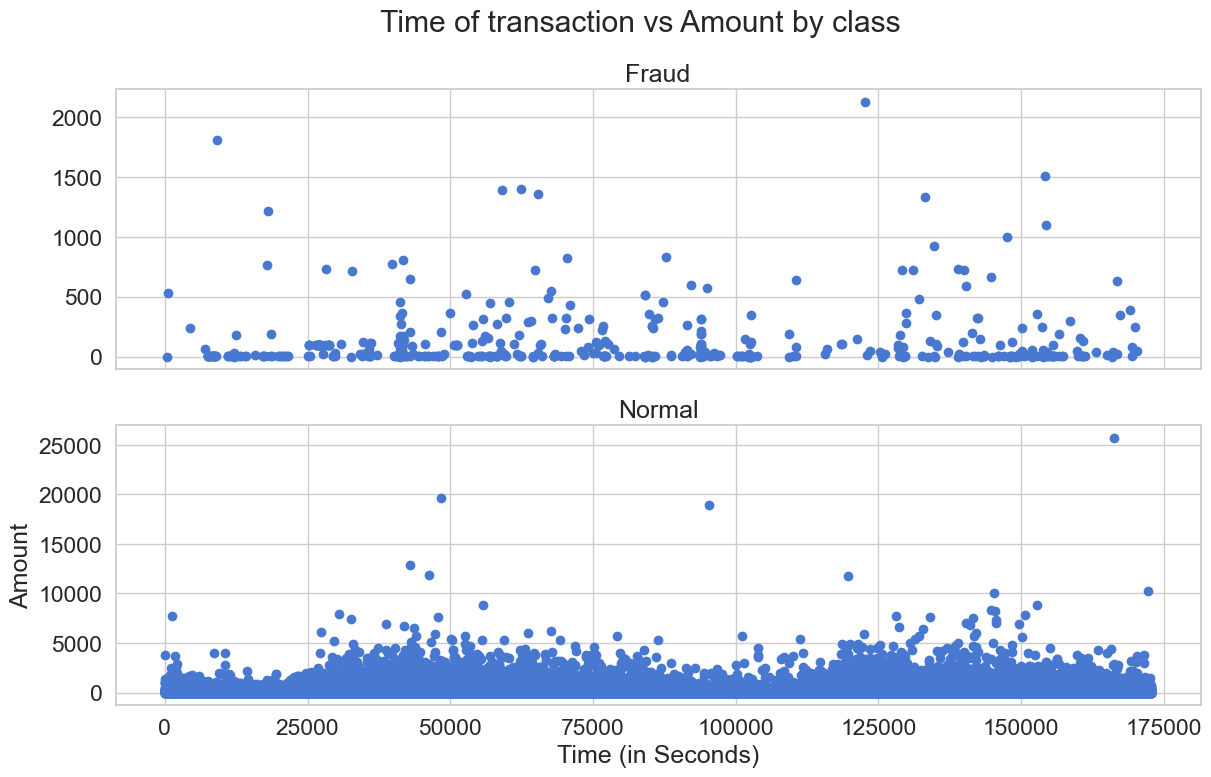

In [28]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [29]:
dataX = df.copy().drop(['Class','Time'],axis=1)
dataY = df['Class'].copy()

In [30]:
featuresToScale = dataX.columns
featuresToScale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [31]:
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [32]:
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [33]:
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [34]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [35]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision  ### diff

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2303 - accuracy: 0.6578 - val_loss: 0.0212 - val_accuracy: 0.9214
Epoch 2/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1320 - accuracy: 0.7223 - val_loss: 0.0166 - val_accuracy: 0.9230
Epoch 3/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1267 - accuracy: 0.7278 - val_loss: 0.0167 - val_accuracy: 0.9234
Epoch 4/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1202 - accuracy: 0.7328 - val_loss: 0.0134 - val_accuracy: 0.9241
Epoch 5/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1185 - accuracy: 0.7352 - val_loss: 0.0136 - val_accuracy: 0.9166
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1151 - accuracy: 0.7357 - val_loss: 0.0139 - val_accuracy: 0.9233
Epoch 7/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1154 - accuracy: 0.7373 - val_loss: 0.0128 - val_accuracy

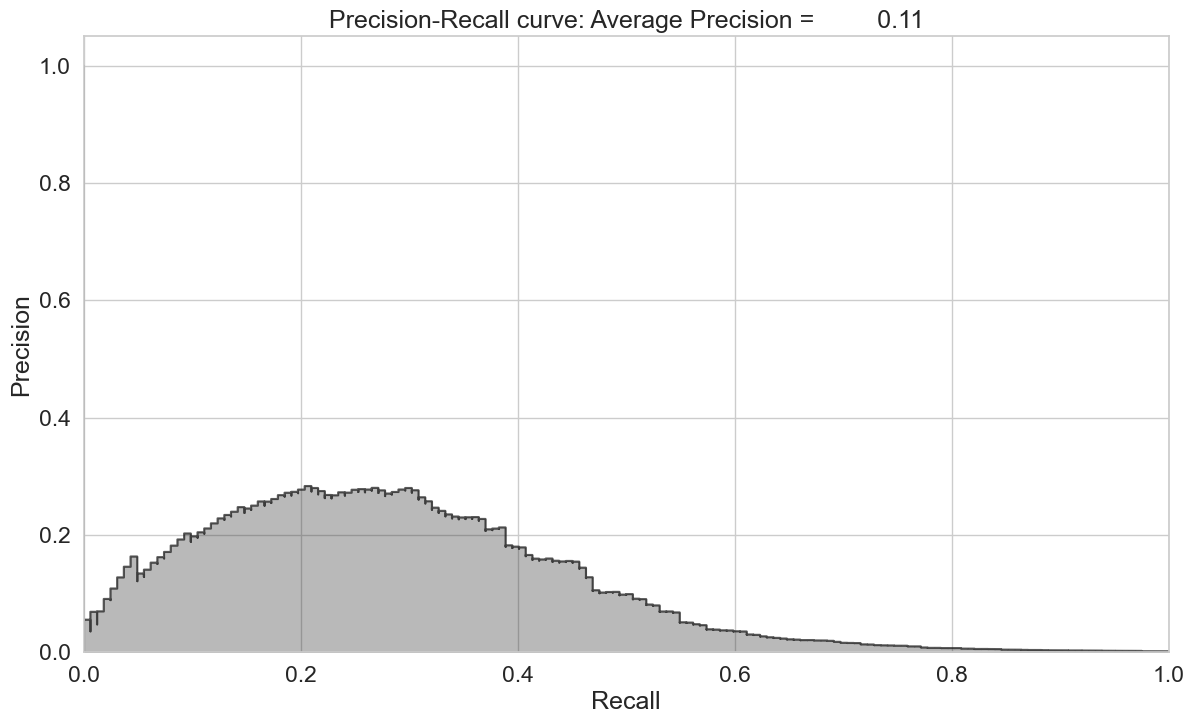

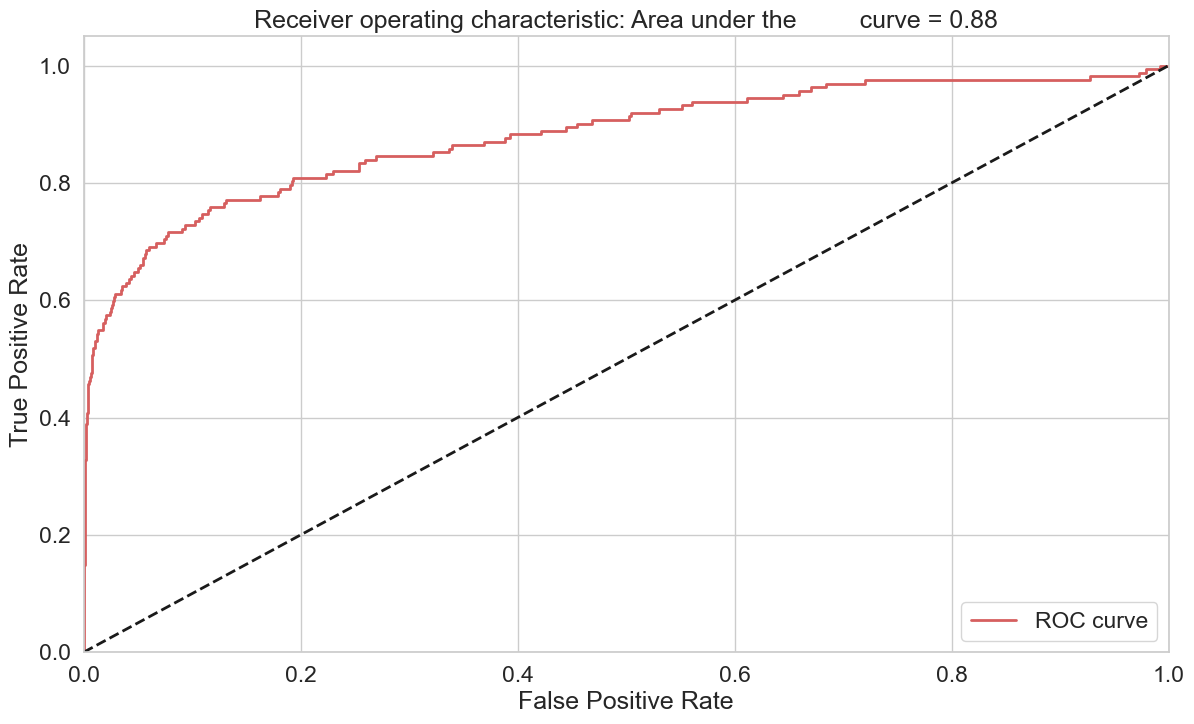

Epoch 1/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.2296 - accuracy: 0.6567 - val_loss: 0.0211 - val_accuracy: 0.9183
Epoch 2/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1303 - accuracy: 0.7227 - val_loss: 0.0164 - val_accuracy: 0.9230
Epoch 3/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1230 - accuracy: 0.7274 - val_loss: 0.0163 - val_accuracy: 0.9178
Epoch 4/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1196 - accuracy: 0.7322 - val_loss: 0.0140 - val_accuracy: 0.9265
Epoch 5/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1173 - accuracy: 0.7351 - val_loss: 0.0138 - val_accuracy: 0.9229
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1162 - accuracy: 0.7406 - val_loss: 0.0164 - val_accuracy: 0.9140
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1133 - accuracy: 0.7404 - val_loss: 0.0114 - val_accuracy:

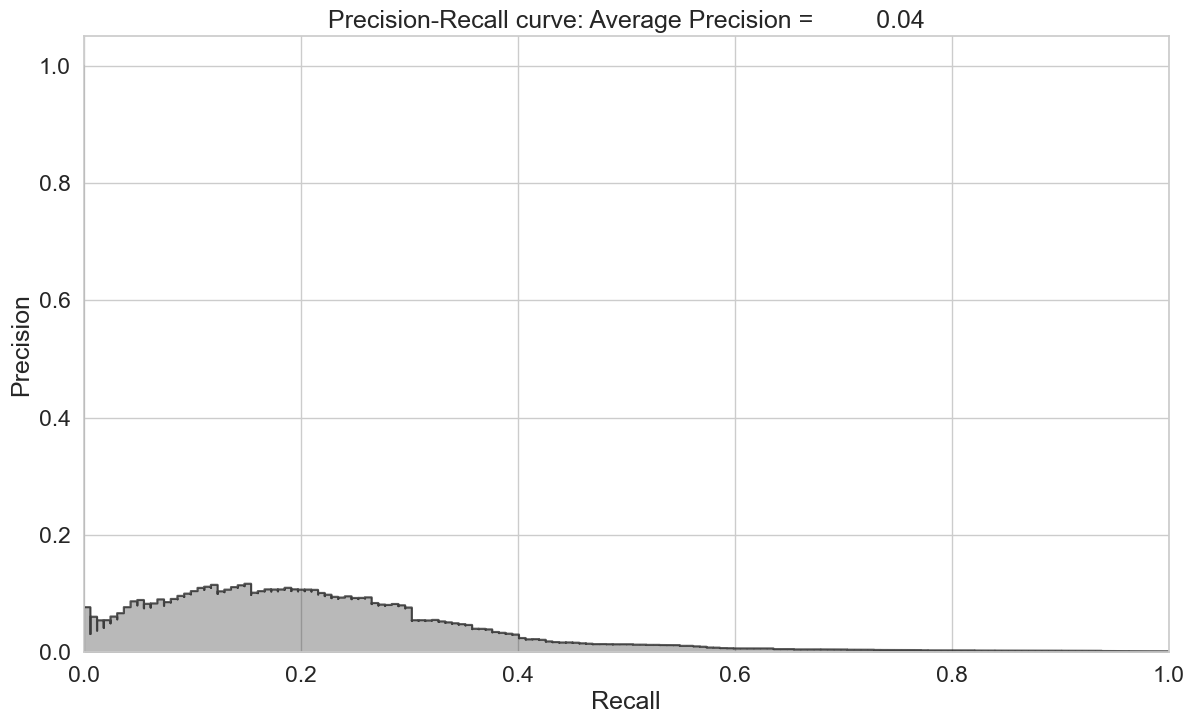

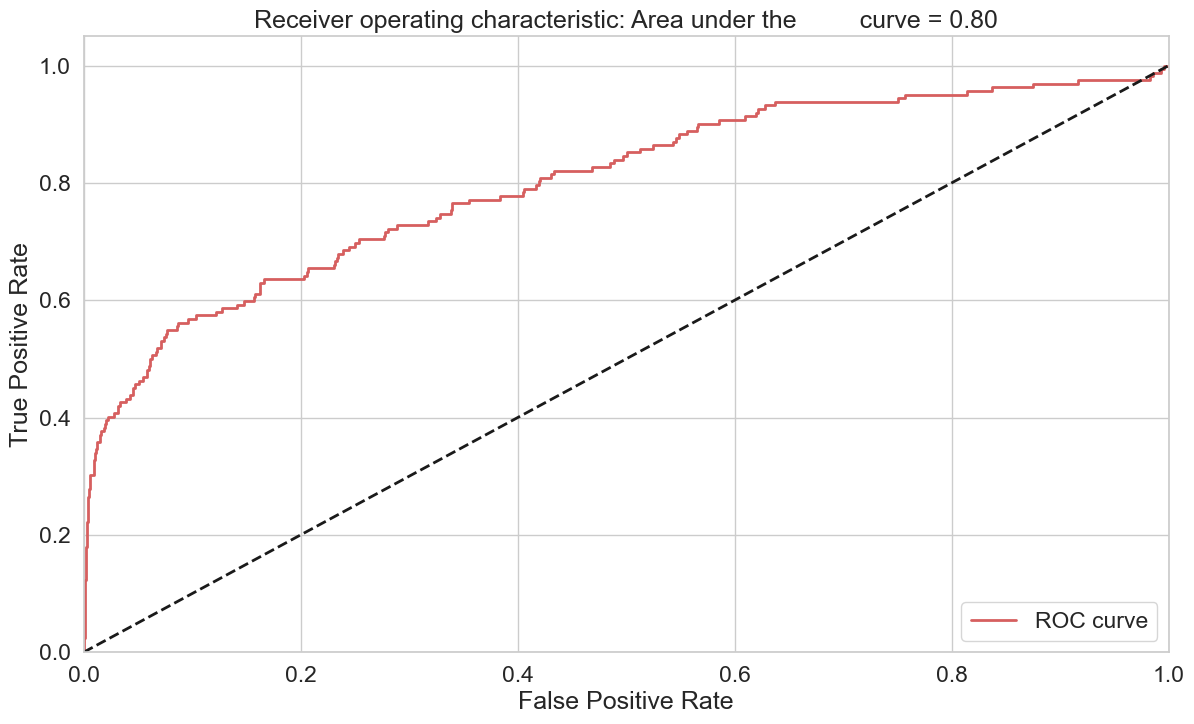

Epoch 1/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.2326 - accuracy: 0.6585 - val_loss: 0.0193 - val_accuracy: 0.9274
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1306 - accuracy: 0.7294 - val_loss: 0.0165 - val_accuracy: 0.9190
Epoch 3/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1273 - accuracy: 0.7346 - val_loss: 0.0167 - val_accuracy: 0.9285
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1190 - accuracy: 0.7352 - val_loss: 0.0137 - val_accuracy: 0.9192
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1154 - accuracy: 0.7374 - val_loss: 0.0132 - val_accuracy: 0.9311
Epoch 6/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1166 - accuracy: 0.7391 - val_loss: 0.0157 - val_accuracy: 0.9175
Epoch 7/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1144 - accuracy: 0.7384 - val_loss: 0.0117 - val_accuracy:

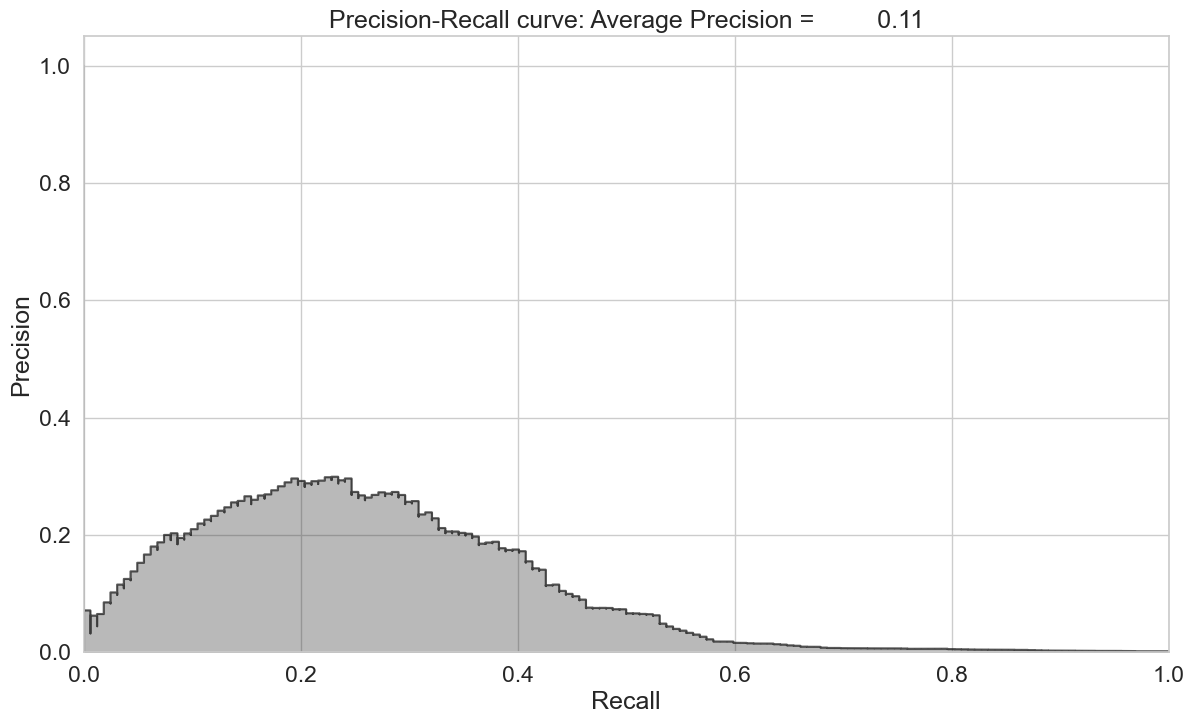

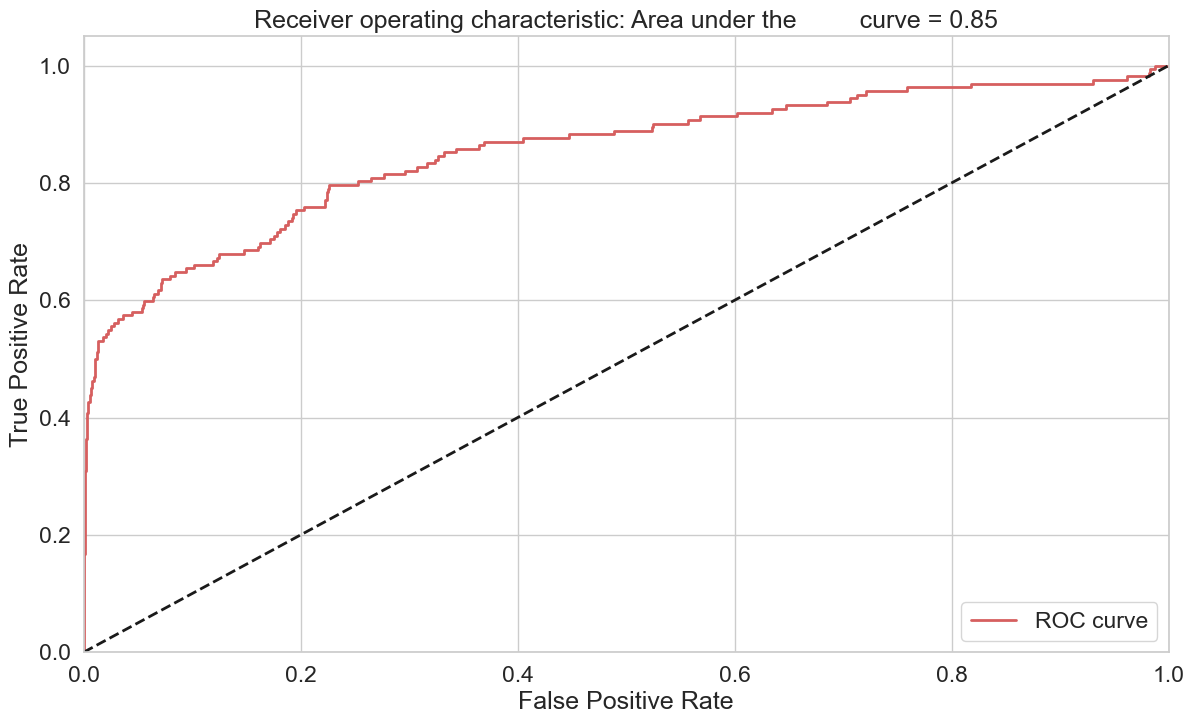

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2276 - accuracy: 0.6561 - val_loss: 0.0220 - val_accuracy: 0.9148
Epoch 2/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1311 - accuracy: 0.7206 - val_loss: 0.0166 - val_accuracy: 0.9219
Epoch 3/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1241 - accuracy: 0.7260 - val_loss: 0.0156 - val_accuracy: 0.9168
Epoch 4/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1204 - accuracy: 0.7314 - val_loss: 0.0132 - val_accuracy: 0.9209
Epoch 5/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1157 - accuracy: 0.7328 - val_loss: 0.0133 - val_accuracy: 0.9244
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1149 - accuracy: 0.7356 - val_loss: 0.0138 - val_accuracy: 0.9259
Epoch 7/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1139 - accuracy: 0.7373 - val_loss: 0.0121 - val_accuracy

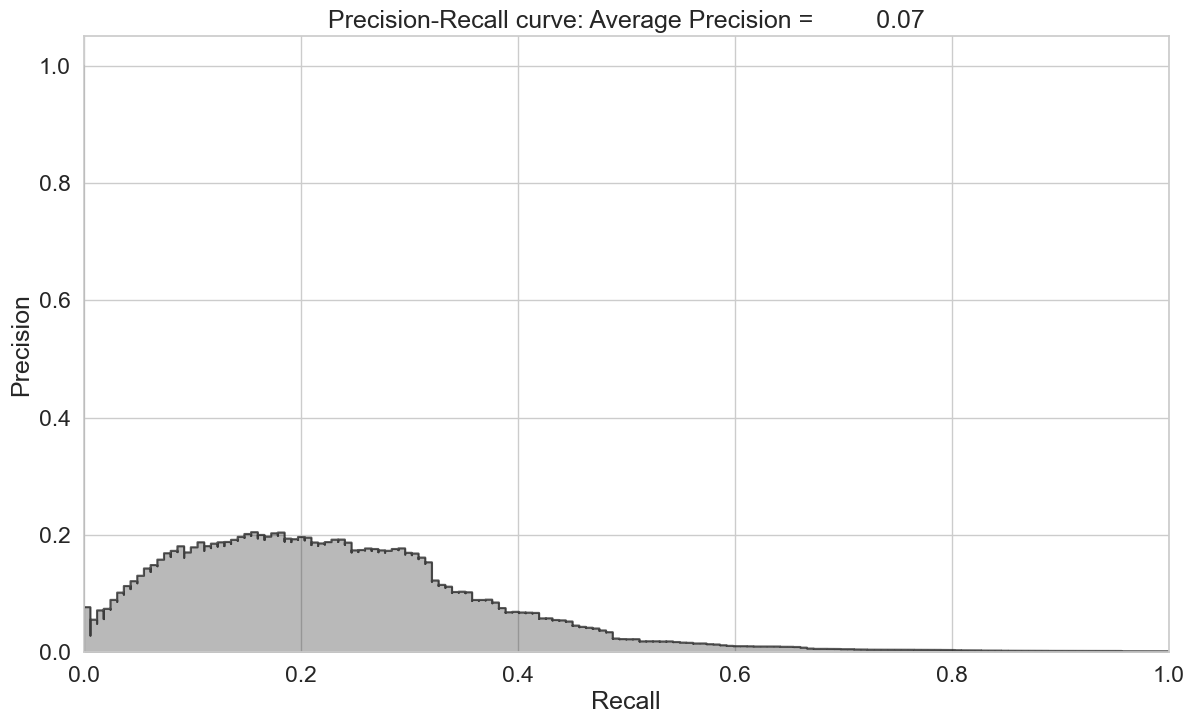

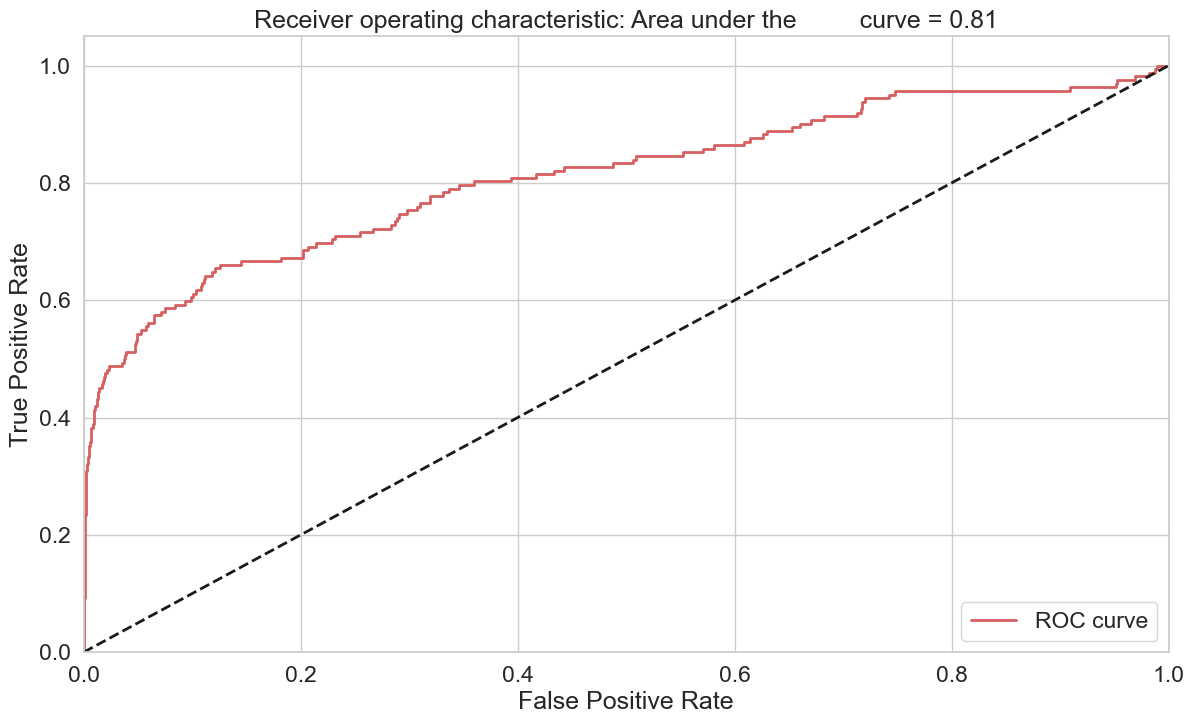

Epoch 1/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.2265 - accuracy: 0.6571 - val_loss: 0.0216 - val_accuracy: 0.9185
Epoch 2/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1297 - accuracy: 0.7246 - val_loss: 0.0168 - val_accuracy: 0.9268
Epoch 3/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1258 - accuracy: 0.7274 - val_loss: 0.0150 - val_accuracy: 0.9210
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1221 - accuracy: 0.7317 - val_loss: 0.0159 - val_accuracy: 0.9162
Epoch 5/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1178 - accuracy: 0.7362 - val_loss: 0.0137 - val_accuracy: 0.9212
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1153 - accuracy: 0.7358 - val_loss: 0.0246 - val_accuracy: 0.8591
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1138 - accuracy: 0.7363 - val_loss: 0.0123 - val_accuracy:

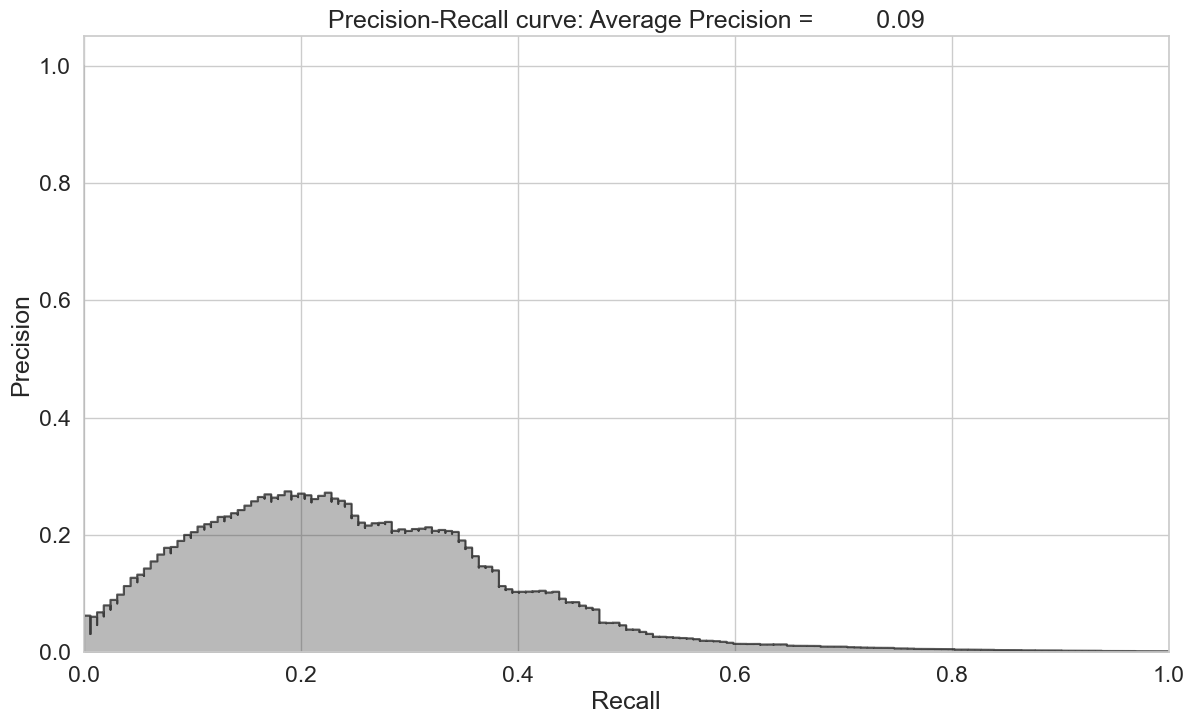

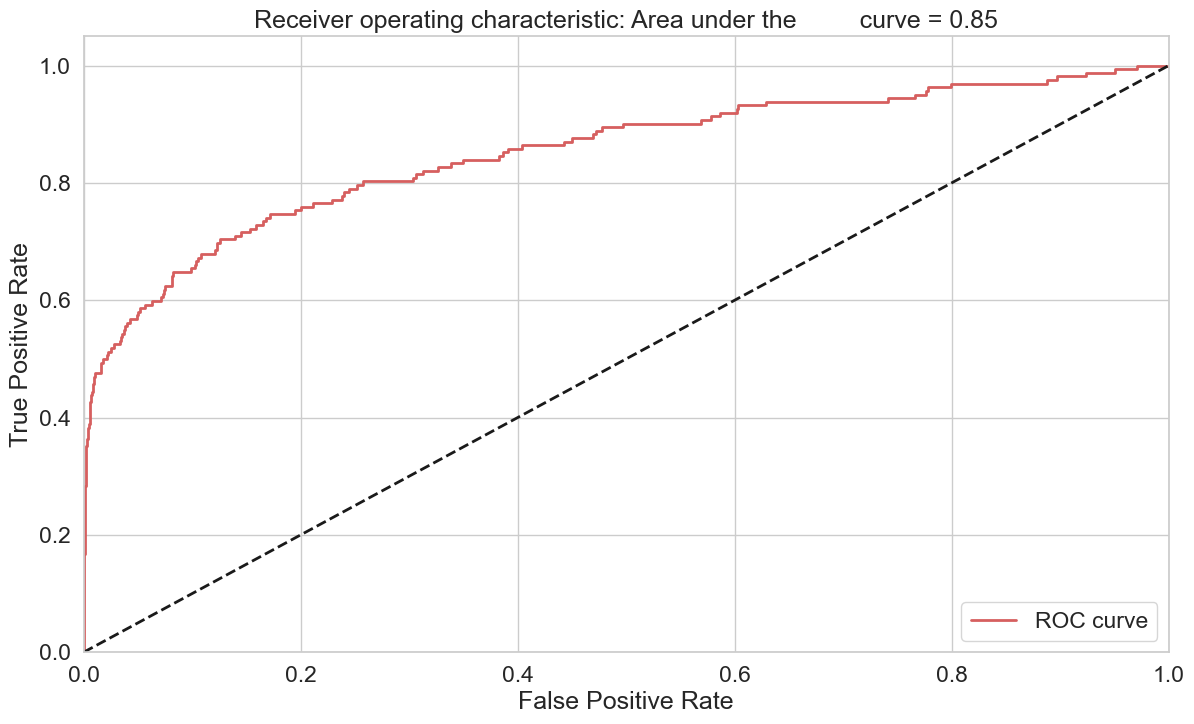

Epoch 1/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.2346 - accuracy: 0.6536 - val_loss: 0.0209 - val_accuracy: 0.9188
Epoch 2/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1311 - accuracy: 0.7216 - val_loss: 0.0164 - val_accuracy: 0.9226
Epoch 3/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1255 - accuracy: 0.7270 - val_loss: 0.0152 - val_accuracy: 0.9192
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1205 - accuracy: 0.7313 - val_loss: 0.0142 - val_accuracy: 0.9186
Epoch 5/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1169 - accuracy: 0.7348 - val_loss: 0.0133 - val_accuracy: 0.9210
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1159 - accuracy: 0.7376 - val_loss: 0.0132 - val_accuracy: 0.9224
Epoch 7/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1147 - accuracy: 0.7377 - val_loss: 0.0129 - val_accuracy:

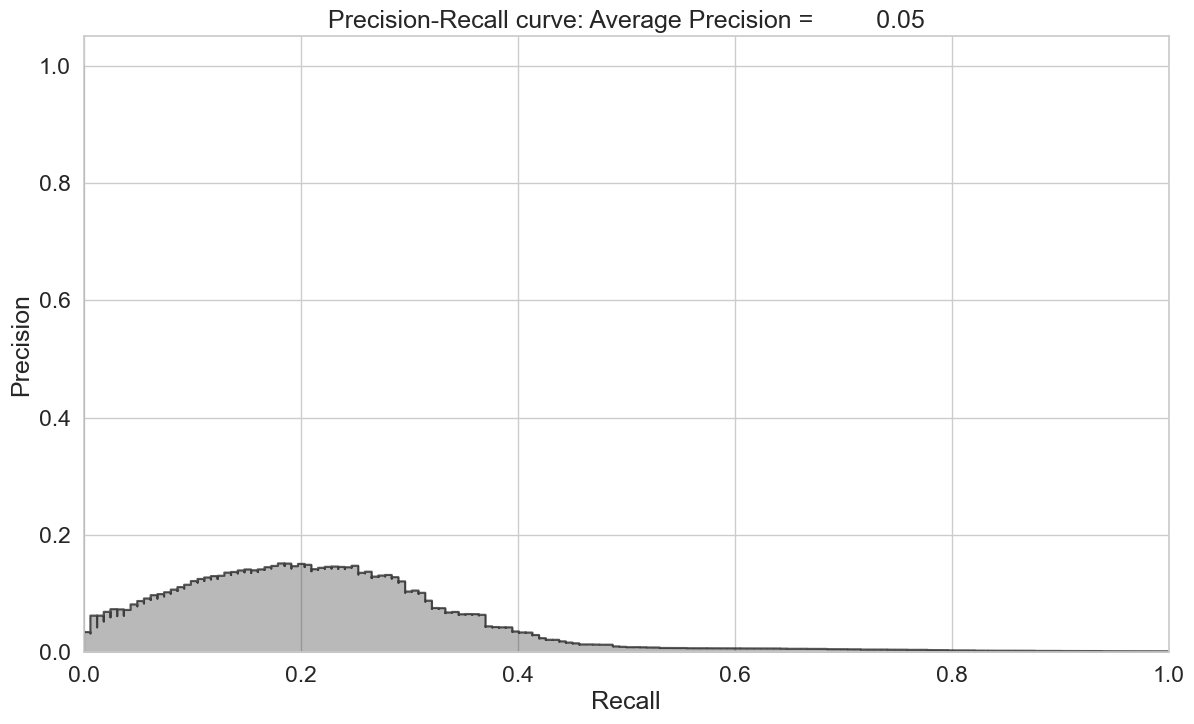

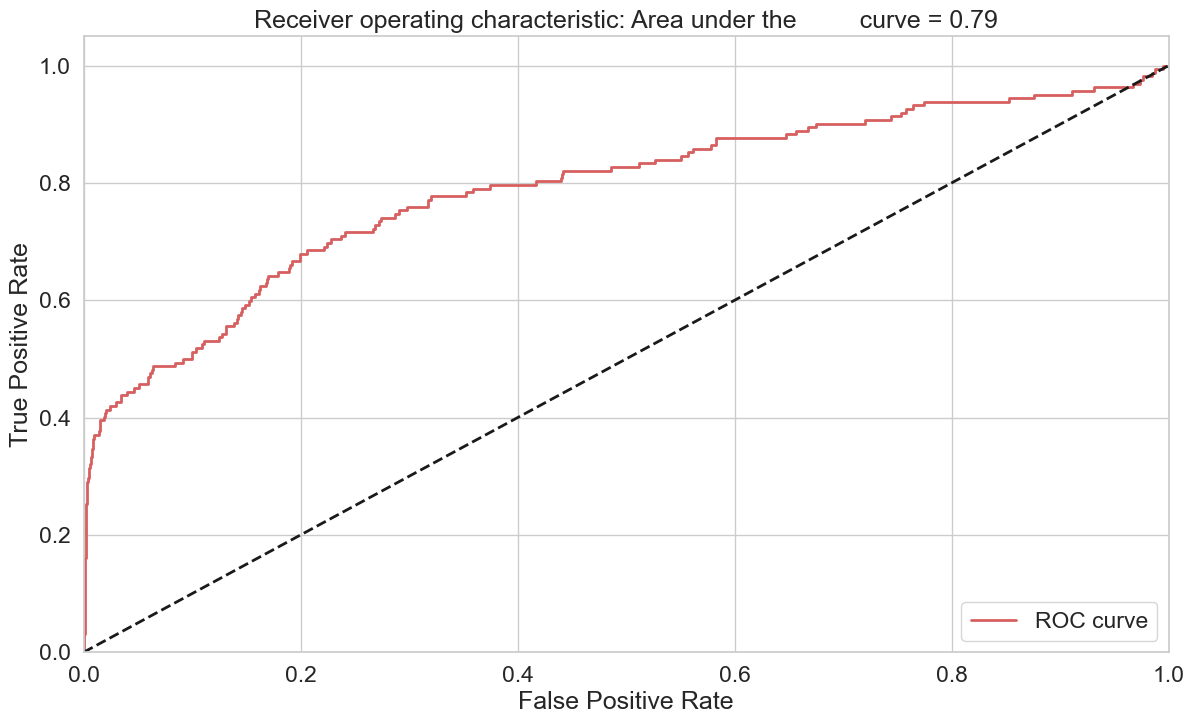

Epoch 1/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.2345 - accuracy: 0.6544 - val_loss: 0.0223 - val_accuracy: 0.9180
Epoch 2/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1317 - accuracy: 0.7249 - val_loss: 0.0171 - val_accuracy: 0.9220
Epoch 3/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1273 - accuracy: 0.7286 - val_loss: 0.0158 - val_accuracy: 0.9270
Epoch 4/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1197 - accuracy: 0.7338 - val_loss: 0.0154 - val_accuracy: 0.9153
Epoch 5/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1182 - accuracy: 0.7375 - val_loss: 0.0136 - val_accuracy: 0.9228
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1154 - accuracy: 0.7374 - val_loss: 0.0136 - val_accuracy: 0.9192
Epoch 7/10
5964/5964 [==============================] - 8s 1ms/step - loss: 0.1147 - accuracy: 0.7382 - val_loss: 0.0131 - val_accuracy:

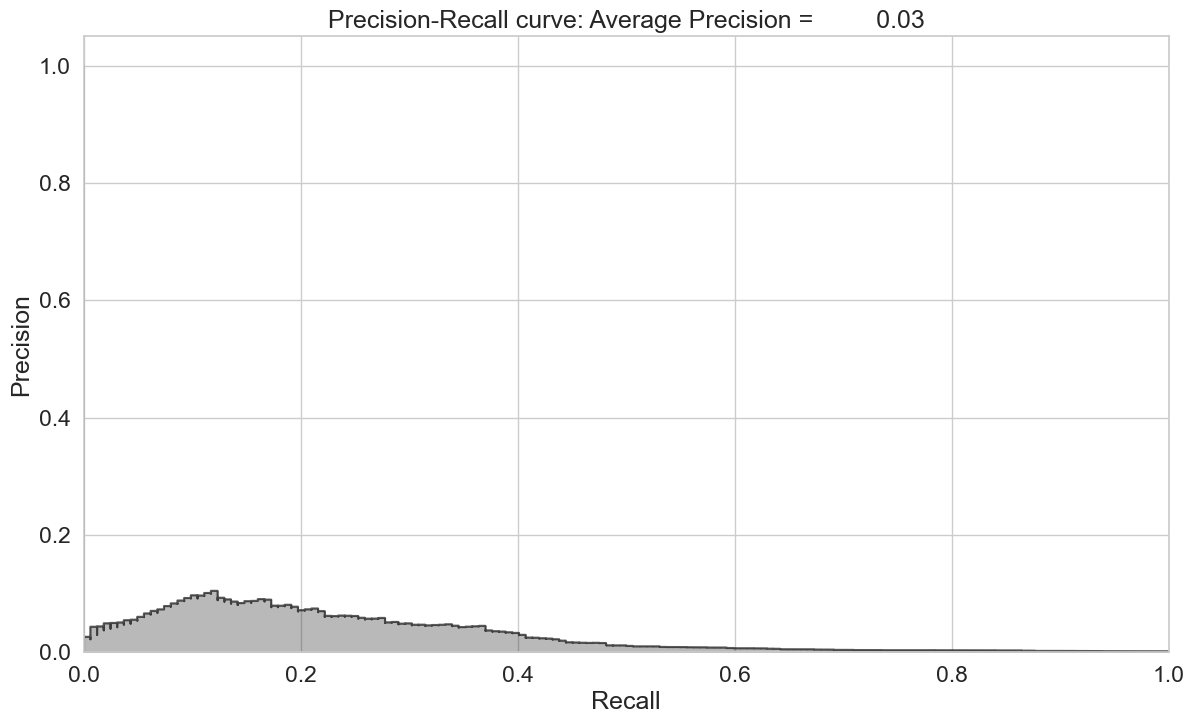

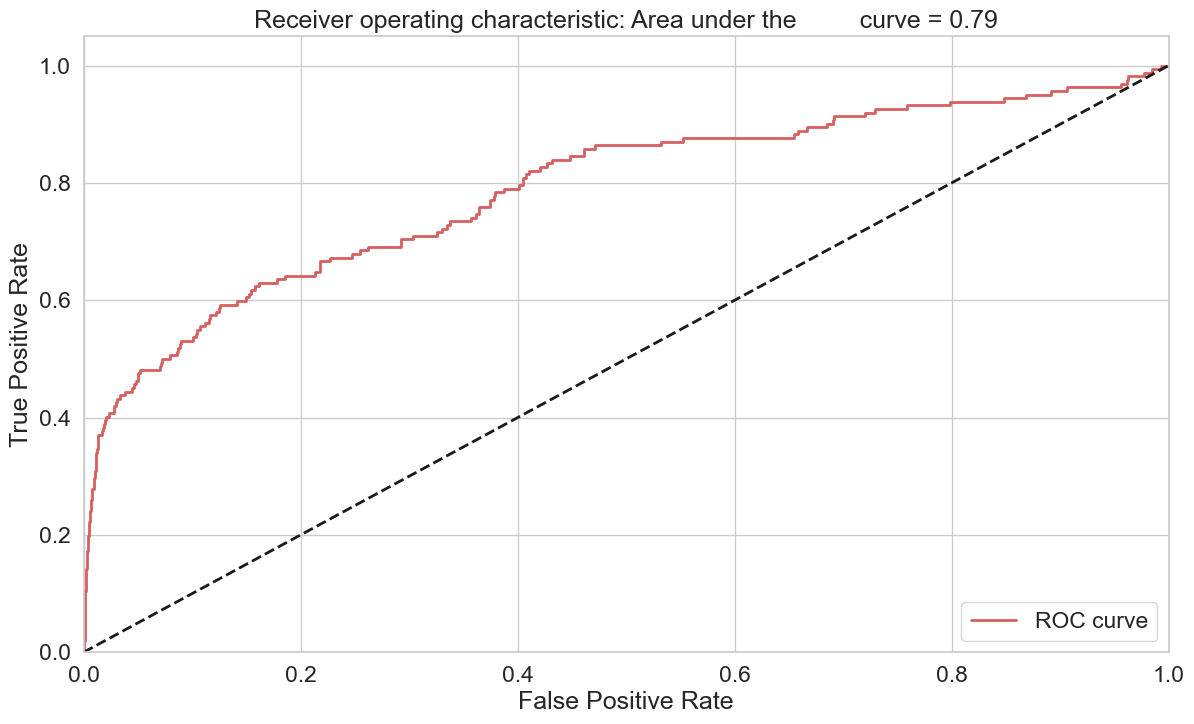

Epoch 1/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.2123 - accuracy: 0.6649 - val_loss: 0.0201 - val_accuracy: 0.9178
Epoch 2/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1306 - accuracy: 0.7219 - val_loss: 0.0160 - val_accuracy: 0.9236
Epoch 3/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1234 - accuracy: 0.7304 - val_loss: 0.0146 - val_accuracy: 0.9202
Epoch 4/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1198 - accuracy: 0.7339 - val_loss: 0.0131 - val_accuracy: 0.9256
Epoch 5/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1152 - accuracy: 0.7379 - val_loss: 0.0133 - val_accuracy: 0.9196
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1134 - accuracy: 0.7400 - val_loss: 0.0125 - val_accuracy: 0.9283
Epoch 7/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1133 - accuracy: 0.7411 - val_loss: 0.0111 - val_accuracy:

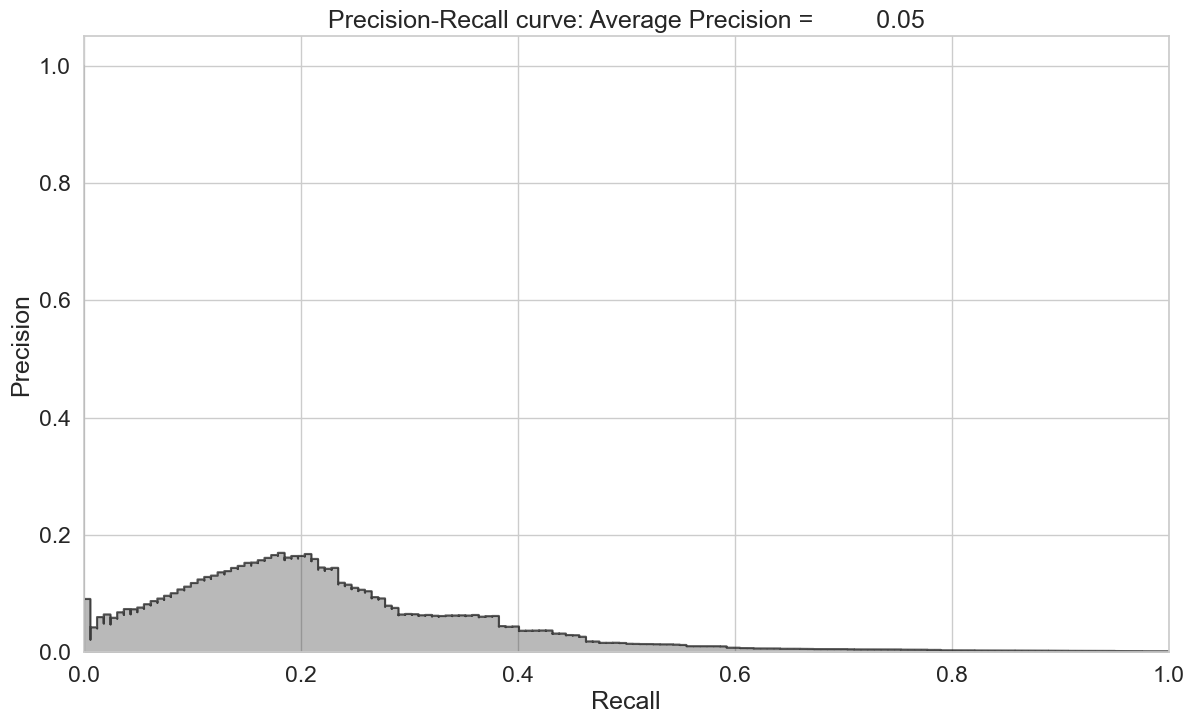

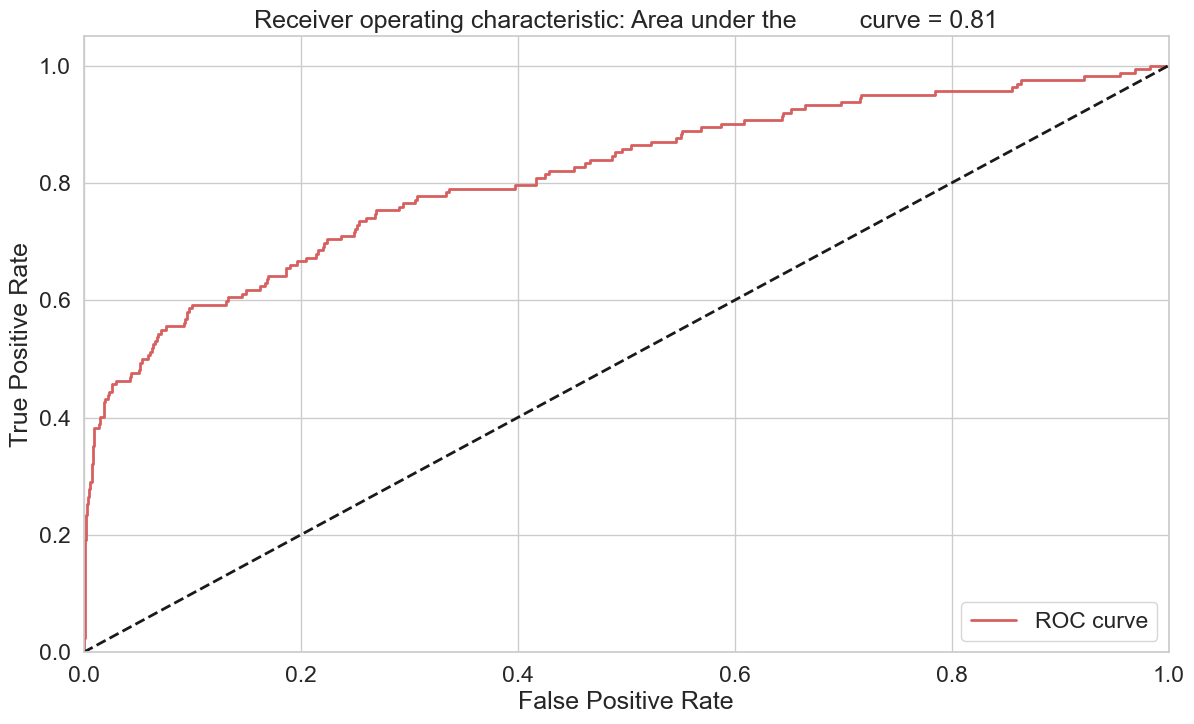

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.2281 - accuracy: 0.6509 - val_loss: 0.0238 - val_accuracy: 0.8934
Epoch 2/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1298 - accuracy: 0.7217 - val_loss: 0.0169 - val_accuracy: 0.9133
Epoch 3/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1233 - accuracy: 0.7290 - val_loss: 0.0153 - val_accuracy: 0.9193
Epoch 4/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1203 - accuracy: 0.7322 - val_loss: 0.0142 - val_accuracy: 0.9230
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1177 - accuracy: 0.7333 - val_loss: 0.0130 - val_accuracy: 0.9262
Epoch 6/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.1162 - accuracy: 0.7340 - val_loss: 0.0130 - val_accuracy: 0.9278
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.1158 - accuracy: 0.7377 - val_loss: 0.0125 - val_ac

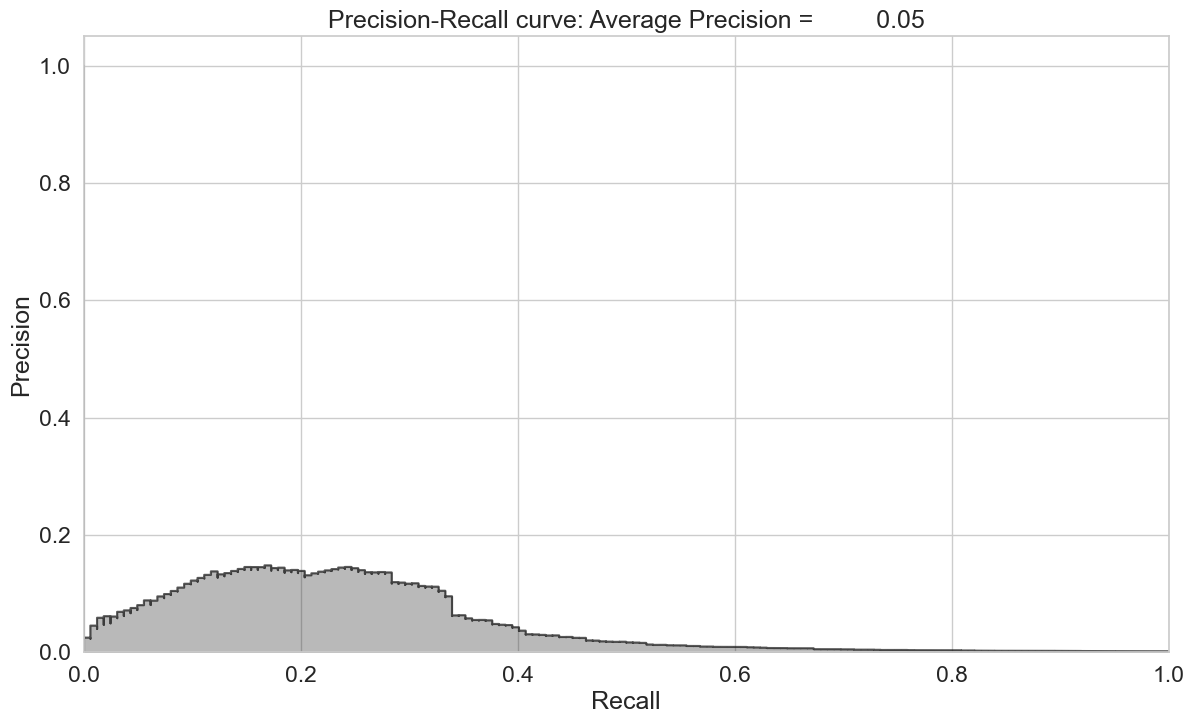

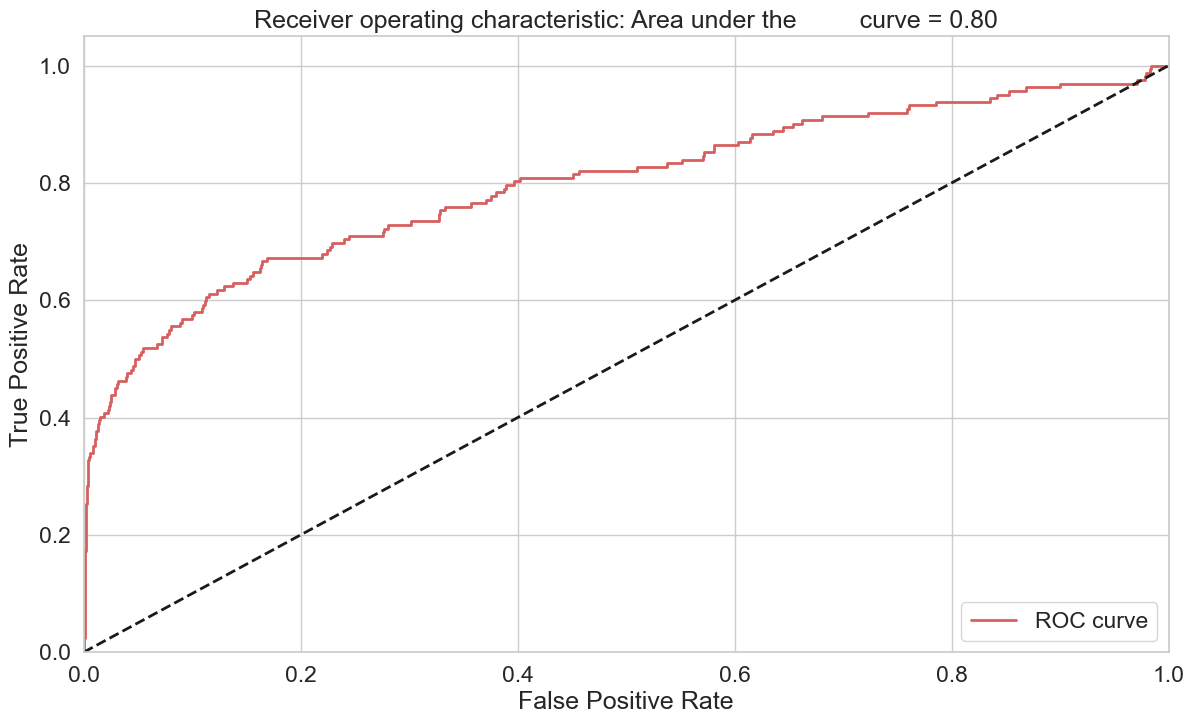

Epoch 1/10
5964/5964 [==============================] - 10s 2ms/step - loss: 0.2297 - accuracy: 0.6563 - val_loss: 0.0202 - val_accuracy: 0.9166
Epoch 2/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1308 - accuracy: 0.7233 - val_loss: 0.0160 - val_accuracy: 0.9251
Epoch 3/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1237 - accuracy: 0.7312 - val_loss: 0.0155 - val_accuracy: 0.9166
Epoch 4/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1209 - accuracy: 0.7328 - val_loss: 0.0139 - val_accuracy: 0.9207
Epoch 5/10
5964/5964 [==============================] - 9s 2ms/step - loss: 0.1172 - accuracy: 0.7364 - val_loss: 0.0127 - val_accuracy: 0.9291
Epoch 6/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1146 - accuracy: 0.7391 - val_loss: 0.0122 - val_accuracy: 0.9258
Epoch 7/10
5964/5964 [==============================] - 9s 1ms/step - loss: 0.1144 - accuracy: 0.7375 - val_loss: 0.0129 - val_accuracy

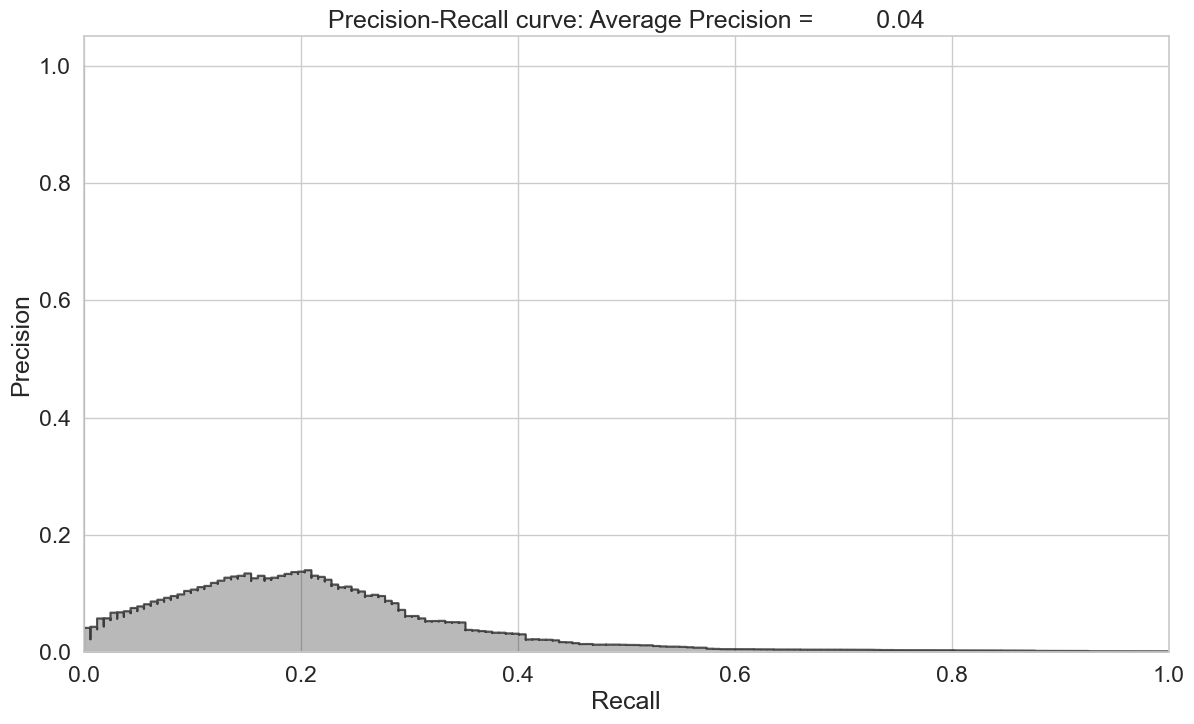

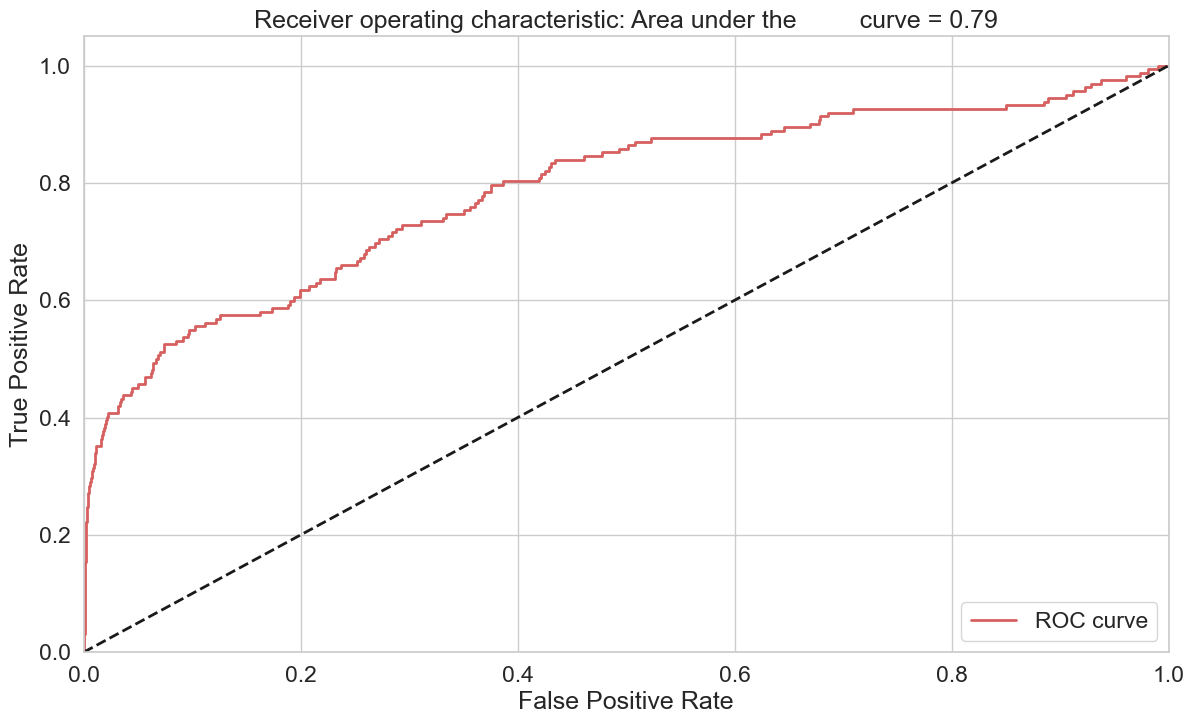

Mean average precision over 10 runs:  0.0626586900375694


[0.11305348487345972,
 0.03680816397682988,
 0.10578715993746911,
 0.06908275345762194,
 0.09199735738224761,
 0.04689494809337373,
 0.029642549540948006,
 0.0457781223387705,
 0.04816042255618265,
 0.03938193821879072]

In [36]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수를 가진 40개 노드를 가진 은닉층 생성
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [37]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.0626586900375694
Coefficient of variation over 10 runs:  0.4610465810088213


[0.11305348487345972,
 0.03680816397682988,
 0.10578715993746911,
 0.06908275345762194,
 0.09199735738224761,
 0.04689494809337373,
 0.029642549540948006,
 0.0457781223387705,
 0.04816042255618265,
 0.03938193821879072]